## Predicción clasificacion de arándanos (MyBlueberryNights)

Se trata de un problema de clasificación binaria (dos tipos de arándanos, última columna) que se clasifican de acuerdo a las
características ( (las primeras 7 columnas de la excel)  que se extraen de las imágenes (área, eje mayor, eje menor, excentricidad....)

Tenéis hasta el 5 de abril para hacer un modelo; el 6 de abril os enviaré un conjunto de entradas y tenéis hasta el 9 de abril para
enviarme las salidas según vuestro modelo. La medida que usaremos será la AUC.


### 1 Imports

In [1]:
# Minimal (Core Libraries)
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### 2 Carga y Limpieza de los Datos

In [7]:
data = pd.read_excel(
    "./datamecum_data/entrenamiento.xlsx"
) # Train Set. El conjunto de test es invisible para facilitar la eval en la competicion (Datathon)

In [8]:
data.isna().sum()

Area      39
Emayor    34
Emenor    37
Exc       44
Vol       43
Rat       40
Perim     47
Clase      0
dtype: int64

In [9]:
data.shape[0]

720

In [10]:
data.describe()

,Area,Emayor,Emenor,Exc,Vol,Rat,Perim
count,681.000000,686.000000,683.000000,676.000000,677.000000,680.000000,673.000000
mean,88262.286344,431.197846,255.521046,1.781422,91020.830133,1.698053,1167.043938
std,38589.316130,115.843789,49.624764,0.090054,39822.725399,0.053060,267.437031
min,25387.000000,225.629541,143.710872,1.348730,26139.000000,1.379856,619.074000
25%,60199.000000,345.601388,219.586405,1.744768,61496.000000,1.668171,970.754000
50%,79735.000000,409.213840,248.606869,1.798546,82555.000000,1.704924,1129.072000
75%,105053.000000,496.804625,286.957802,1.841674,108296.000000,1.733535,1313.092000
max,235047.000000,997.291941,440.497127,1.962124,239093.000000,1.830632,2303.690000


In [11]:
data.head()

,Area,Emayor,Emenor,Exc,Vol,Rat,Perim,Clase
0,100928.0,465.179920,287.015714,1.786964,105549.0,1.686193,1310.510,B
1,77622.0,460.142902,226.581322,1.870360,82990.0,1.651213,1205.141,B
2,57612.0,352.441365,210.064210,1.802965,58810.0,1.647719,934.684,A
3,75166.0,406.690687,243.032436,1.801805,78789.0,1.684130,1121.786,A
4,80437.0,449.454581,232.325506,1.856043,84460.0,1.674236,1176.305,A


In [12]:
# 1. Datos Crudos
data["Clase"].value_counts()

B    362
A    358
Name: Clase, dtype: int64

In [13]:
# 2. Datos sin valores nulos (`NaNs`) (filtrados)
data.dropna()["Clase"].value_counts()

A    245
B    239
Name: Clase, dtype: int64

* Variable Respuesta bien balanceada (incluso después de limpieza de valores nulos). Pero reduce enormemente el Conjunto -> `SimpleImputer()`

In [14]:
data.describe().loc[["mean","std"],:] # Dataset Original

,Area,Emayor,Emenor,Exc,Vol,Rat,Perim
mean,88262.286344,431.197846,255.521046,1.781422,91020.830133,1.698053,1167.043938
std,38589.316130,115.843789,49.624764,0.090054,39822.725399,0.053060,267.437031


In [15]:
data.dropna().describe().loc[["mean","std"],:] # Dataset con los valores nulos filtrados

,Area,Emayor,Emenor,Exc,Vol,Rat,Perim
mean,86709.958678,427.925454,253.333889,1.778472,89982.82438,1.697786,1158.673388
std,37798.700043,113.841517,47.353312,0.095169,39236.05545,0.052282,265.004612


*Conclusión:* Eliminar datos faltantes tiene muy poco impacto en los descriptivos (en sentido media-varianza), por lo que, a lo largo del resto del cuaderno, trabajaremos con el dataset limpio de `NaNs` y sin imputación alguna de los valores faltantes.

In [16]:
data_c = data.copy()

In [17]:
data.dropna(inplace=True)

In [18]:
# Double Check
data.isna().sum()

Area      0
Emayor    0
Emenor    0
Exc       0
Vol       0
Rat       0
Perim     0
Clase     0
dtype: int64

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 484 entries, 0 to 718
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Area    484 non-null    float64
 1   Emayor  484 non-null    float64
 2   Emenor  484 non-null    float64
 3   Exc     484 non-null    float64
 4   Vol     484 non-null    float64
 5   Rat     484 non-null    float64
 6   Perim   484 non-null    float64
 7   Clase   484 non-null    object 
dtypes: float64(7), object(1)
memory usage: 34.0+ KB


### 3 Análisis Exploratorio de los Datos

In [20]:
%whos DataFrame
""" 
`data`: Filtered Data
`data_c`: Complete Data with NaNs (Situacion Real en Produccion) 
"""

Variable   Type         Data/Info
---------------------------------
data       DataFrame             Area      Emayor<...>n\n[484 rows x 8 columns]
data_c     DataFrame             Area      Emayor<...>n\n[720 rows x 8 columns]


In [22]:
%whos

Variable   Type         Data/Info
---------------------------------
data       DataFrame             Area      Emayor<...>n\n[484 rows x 8 columns]
data_c     DataFrame             Area      Emayor<...>n\n[720 rows x 8 columns]
np         module       <module 'numpy' from '/ho<...>kages/numpy/__init__.py'>
pd         module       <module 'pandas' from '/h<...>ages/pandas/__init__.py'>
plt        module       <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
sns        module       <module 'seaborn' from '/<...>ges/seaborn/__init__.py'>


#### 3.1 Preproceso Variables Numéricas

In [21]:
data.head()

,Area,Emayor,Emenor,Exc,Vol,Rat,Perim,Clase
0,100928.0,465.179920,287.015714,1.786964,105549.0,1.686193,1310.510,B
1,77622.0,460.142902,226.581322,1.870360,82990.0,1.651213,1205.141,B
2,57612.0,352.441365,210.064210,1.802965,58810.0,1.647719,934.684,A
3,75166.0,406.690687,243.032436,1.801805,78789.0,1.684130,1121.786,A
4,80437.0,449.454581,232.325506,1.856043,84460.0,1.674236,1176.305,A


In [23]:
features_names = data.columns.tolist()[:-1]
features_names

['Area', 'Emayor', 'Emenor', 'Exc', 'Vol', 'Rat', 'Perim']

2. **Análisis de la Asimetría**

In [24]:
data.skew()

/tmp/ipykernel_8051/1188251951.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.skew()


Area      1.152806
Emayor    0.809336
Emenor    0.648262
Exc      -1.340702
Vol       1.178461
Rat      -0.895476
Perim     0.837303
dtype: float64

3. Además, **gráficamente**, podemos hacernos una idea del grado de asimetría positiva y otras características distribucionales.

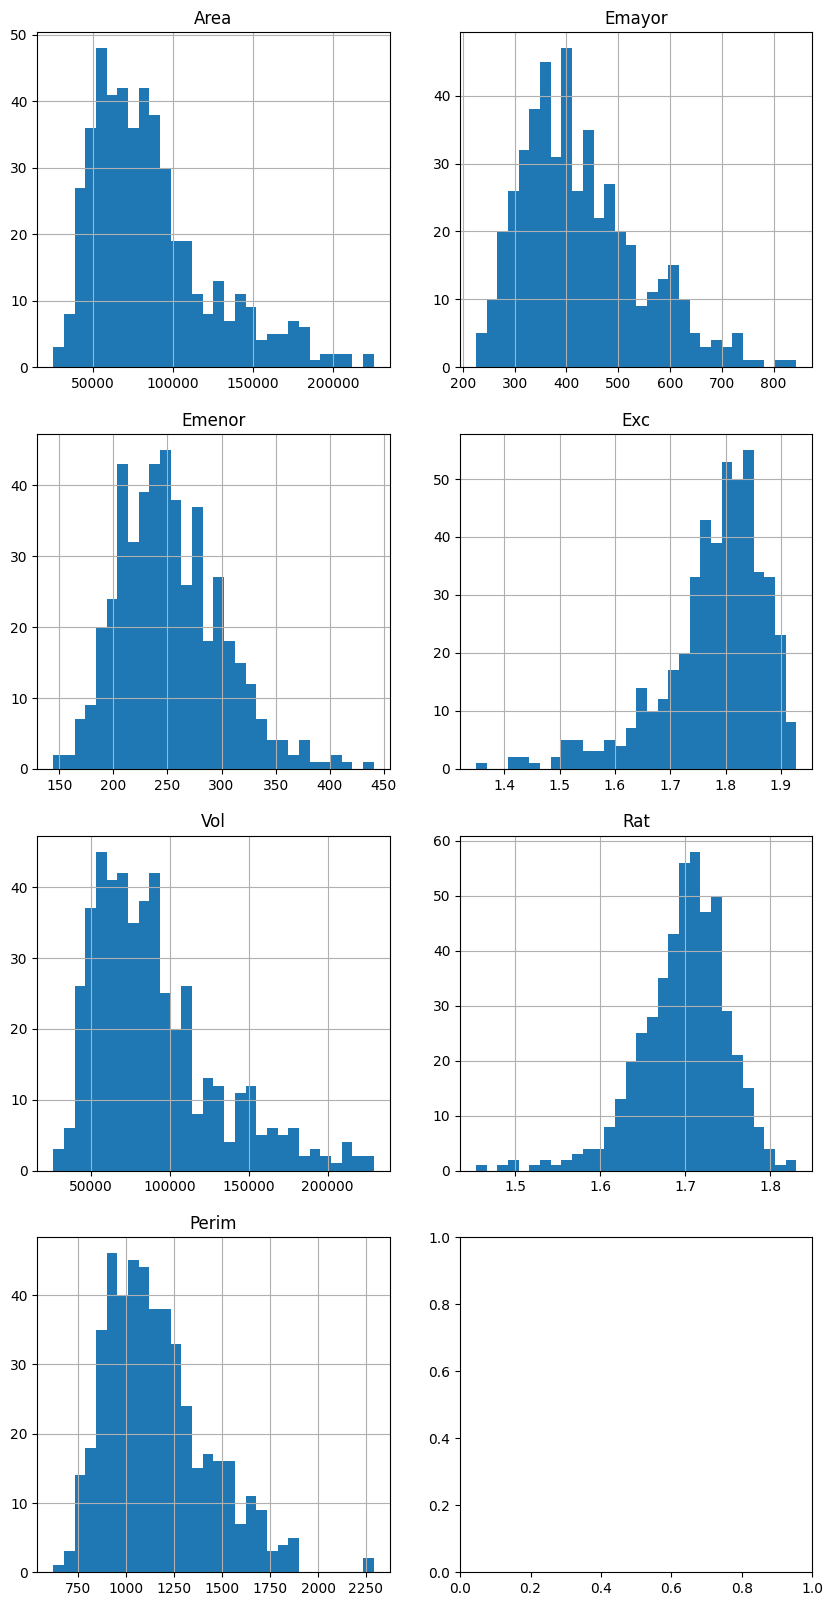

In [25]:
fig,ax = plt.subplots(4,2, figsize=(10,20))

for i,ax in enumerate(ax.flat):
    try:
        ax.hist(data[features_names[i]], bins=30)
        ax.set_title(features_names[i])
        ax.grid()
    except:
        break

La disparidad de escalas y la elevada asimetría positiva sugiere que utilicemos una transformacion (`Scaler`) de tipo `Box-Cox`.
Utilizamos la transformación sobre las variables numéricas para todas las muestras, antes de realizar la partición en conjunto de entrenamiento y test e integrarlas en un `ColumnTransformer()`, dado que queremos visualizar los efectos (beneficiosos) de su aplicación.

In [21]:
data.shape

(484, 8)

In [27]:
from sklearn.preprocessing import PowerTransformer, StandardScaler # 
pt = PowerTransformer(method="box-cox")
# std = StandardScaler()
# data_std = std.fit_transform(data[features_names])
data_pt = pt.fit_transform(data[features_names])

In [28]:
# data_std.shape
data_pt.shape

(484, 7)

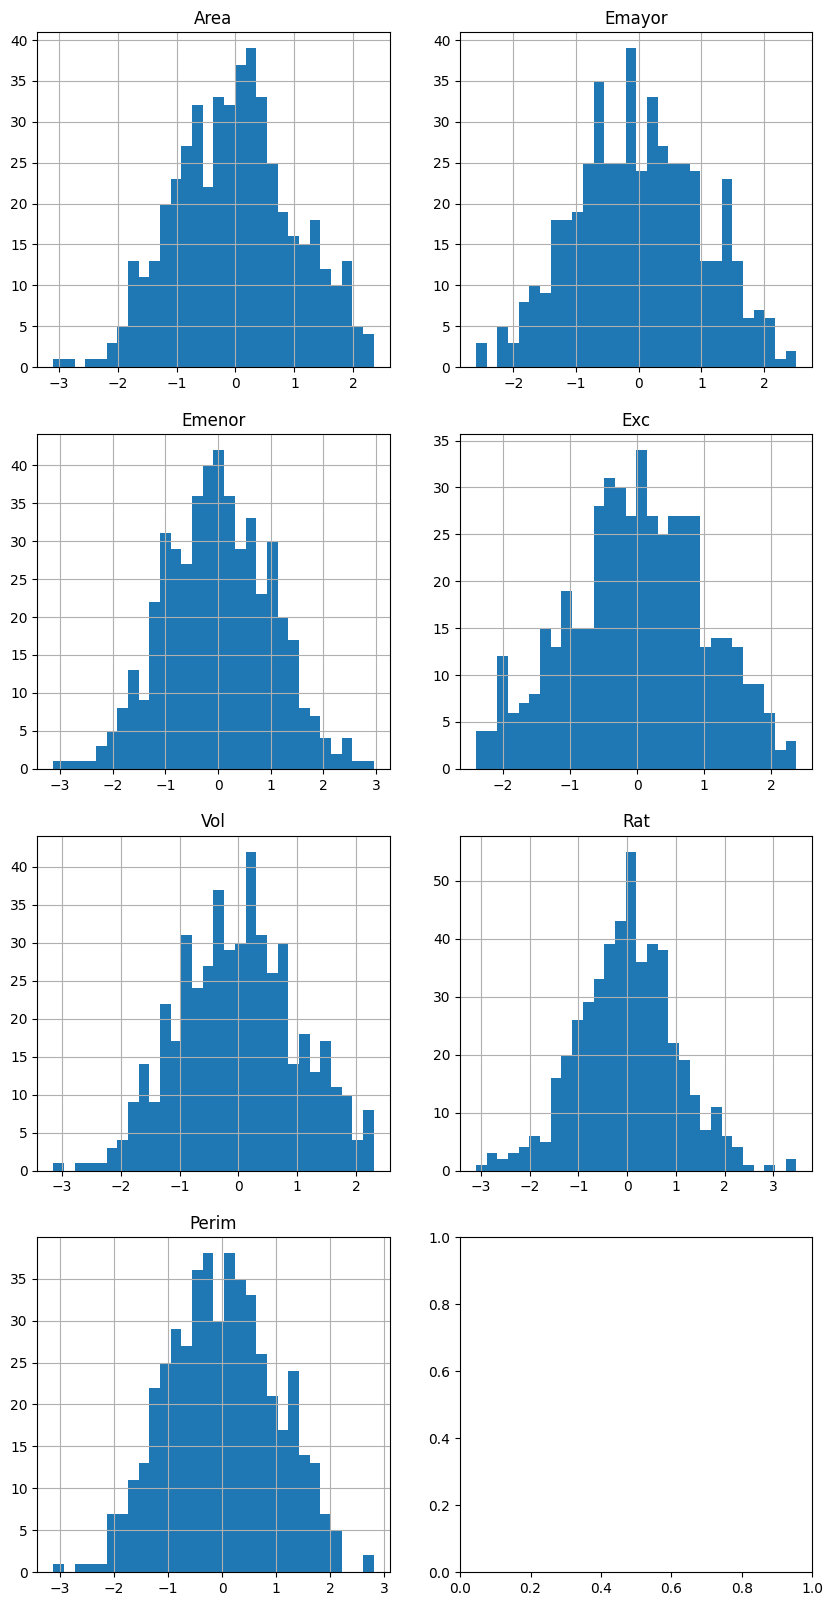

In [29]:
fig,ax = plt.subplots(4,2, figsize=(10,20))

for i,ax in enumerate(ax.flat):
    try:    
        # ax.hist(data_std[:,i], bins=30)
        ax.hist(data_pt[:,i], bins=30)
        ax.set_title(features_names[i])
        ax.grid()
    except:
        break

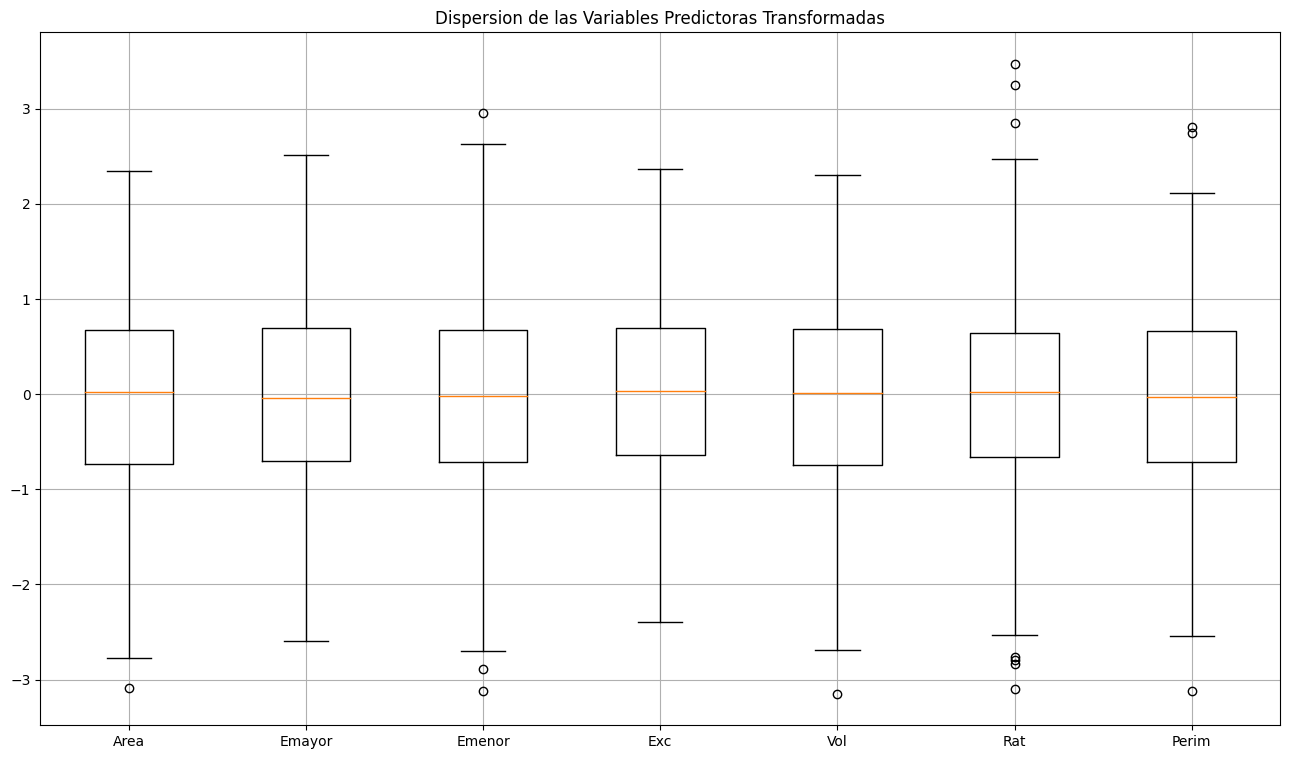

In [30]:
fig,ax = plt.subplots(figsize=(16,9))

ax.boxplot(
    data_pt, 
    labels=features_names,   
    )

ax.set_title("Dispersion de las Variables Predictoras Transformadas")
plt.grid()

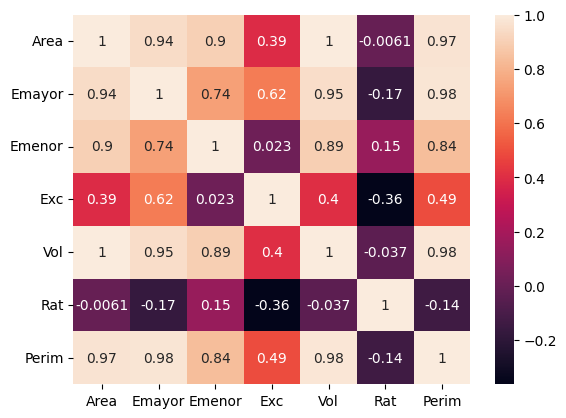

In [32]:
# Multicolinearity First Insights
corr = data.iloc[:,:-1].corr()
sns.heatmap(corr, annot=True);

In [34]:
# data_std_df = pd.DataFrame(
#     data=data_pt,
#     columns=features_names
# )

data_pt_df = pd.DataFrame(
    data=data_pt,
    columns=features_names
)


<AxesSubplot:>

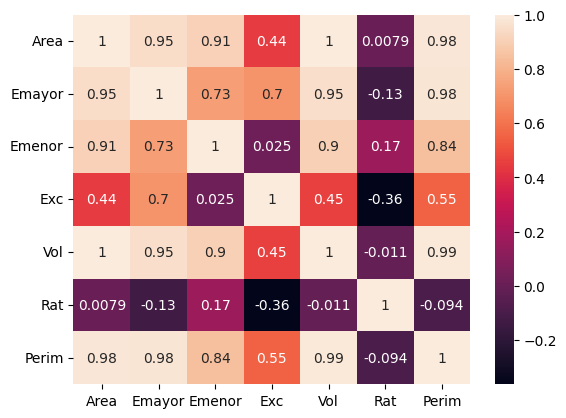

In [36]:
# corr = data_std_df.corr()
# sns.heatmap(corr,annot=True)
corr = data_pt_df.corr()
sns.heatmap(corr,annot=True)

Es bastante evidente que hay fenómeno de multicolinealidad antes y después de transformar, 
por lo que un análisis basado en modelos lineales que relacionen características numéricas mediante `statmodels` y `vif`  nos puede reducir bastante la dimensionalidad.

In [40]:
%whos DataFrame

Variable     Type         Data/Info
-----------------------------------
corr         DataFrame                Area    Emayo<...>88656 -0.093764  1.000000
data         DataFrame             Area      Emayor<...>n\n[484 rows x 8 columns]
data_c       DataFrame             Area      Emayor<...>n\n[720 rows x 8 columns]
data_pt_df   DataFrame             Area    Emayor  <...>n\n[484 rows x 7 columns]


##### 3.1.1 Análisis de la Multicolinealidad

In [41]:
import statsmodels.formula.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

    a) `Perim` frente a resto. Variables Transformadas


In [42]:
features_names

['Area', 'Emayor', 'Emenor', 'Exc', 'Vol', 'Rat', 'Perim']

In [43]:
# right_formula_elements = [feature for feature in numerical_features_simple_names[3:-1]]
right_formula = " + ".join(features_names[:-1])
right_formula

'Area + Emayor + Emenor + Exc + Vol + Rat'

In [44]:
# modelo = sm.ols(
#     formula= "Perim ~ "+right_formula,
#     data=data_std_df
# )
modelo = sm.ols(
    formula= "Perim ~ "+right_formula,
    data=data_pt_df
)


In [45]:
res = modelo.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Perim   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.980e+04
Date:                Sun, 19 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:08:56   Log-Likelihood:                 649.51
No. Observations:                 484   AIC:                            -1285.
Df Residuals:                     477   BIC:                            -1256.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.485e-14      0.003   -1.2e-11      1.000      -0.006       0.006
Area          -1.5318      0.075    -20.365      0.000      -1.680      -1.384
Emayor         0.2891      0.101      2.853      0.005       0.090       0.488
Emenor        -0.1711      0.054     -3.148      0.002      -0.278      -0.064
Exc           -0.0814      0.043     -1.912      0.057      -0.165       0.002
Vol            2.4341      0.101     24.006      0.000       2.235       2.633
Rat           -0.0166      0.003     -4.873      0.000      -0.023      -0.010
==============================================================================
Omnibus:                       17.257   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.304
Skew:                           0.323   Prob(JB):                     8.70e-06
Kurtosis:                       3.859   Cond. No.                         89.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
data_pt_df

,Area,Emayor,Emenor,Exc,Vol,Rat,Perim
0,0.608440,0.492979,0.781415,-0.115940,0.629485,-0.340963,0.703810
1,-0.020462,0.451994,-0.502460,1.165714,0.054456,-0.963448,0.339250
2,-0.774619,-0.601617,-0.927118,0.094318,-0.821020,-1.020538,-0.856675
3,-0.099708,-0.023843,-0.115189,0.078558,-0.073601,-0.380375,0.016093
4,0.066763,0.362990,-0.363478,0.910629,0.097427,-0.564527,0.231255
...,...,...,...,...,...,...,...
479,-1.671182,-1.787930,-1.216623,-1.275538,-1.705949,0.639116,-1.671397
480,0.244085,-0.628890,1.281256,-2.261278,0.183824,2.039810,-0.202674
481,-0.890537,-1.045823,-0.597465,-0.919391,-0.910674,0.231284,-0.993202
482,0.166307,0.289101,-0.062474,0.497674,0.151252,-0.864202,0.207474


In [47]:
features_names

['Area', 'Emayor', 'Emenor', 'Exc', 'Vol', 'Rat', 'Perim']

In [48]:
# data_std_df[features_names[:-1]]
data_pt_df[features_names[:-1]]

,Area,Emayor,Emenor,Exc,Vol,Rat
0,0.608440,0.492979,0.781415,-0.115940,0.629485,-0.340963
1,-0.020462,0.451994,-0.502460,1.165714,0.054456,-0.963448
2,-0.774619,-0.601617,-0.927118,0.094318,-0.821020,-1.020538
3,-0.099708,-0.023843,-0.115189,0.078558,-0.073601,-0.380375
4,0.066763,0.362990,-0.363478,0.910629,0.097427,-0.564527
...,...,...,...,...,...,...
479,-1.671182,-1.787930,-1.216623,-1.275538,-1.705949,0.639116
480,0.244085,-0.628890,1.281256,-2.261278,0.183824,2.039810
481,-0.890537,-1.045823,-0.597465,-0.919391,-0.910674,0.231284
482,0.166307,0.289101,-0.062474,0.497674,0.151252,-0.864202


In [49]:
vif = pd.DataFrame()
subset = data_pt_df[features_names[:-1]]
vif['VIF'] = [variance_inflation_factor(exog=subset.values, exog_idx=i) for i in range(subset.shape[1])]
vif['variable'] = subset.columns
vif

,VIF,variable
0,674.916431,Area
1,1225.004185,Emayor
2,352.452544,Emenor
3,216.565009,Exc
4,1226.455495,Vol
5,1.388041,Rat


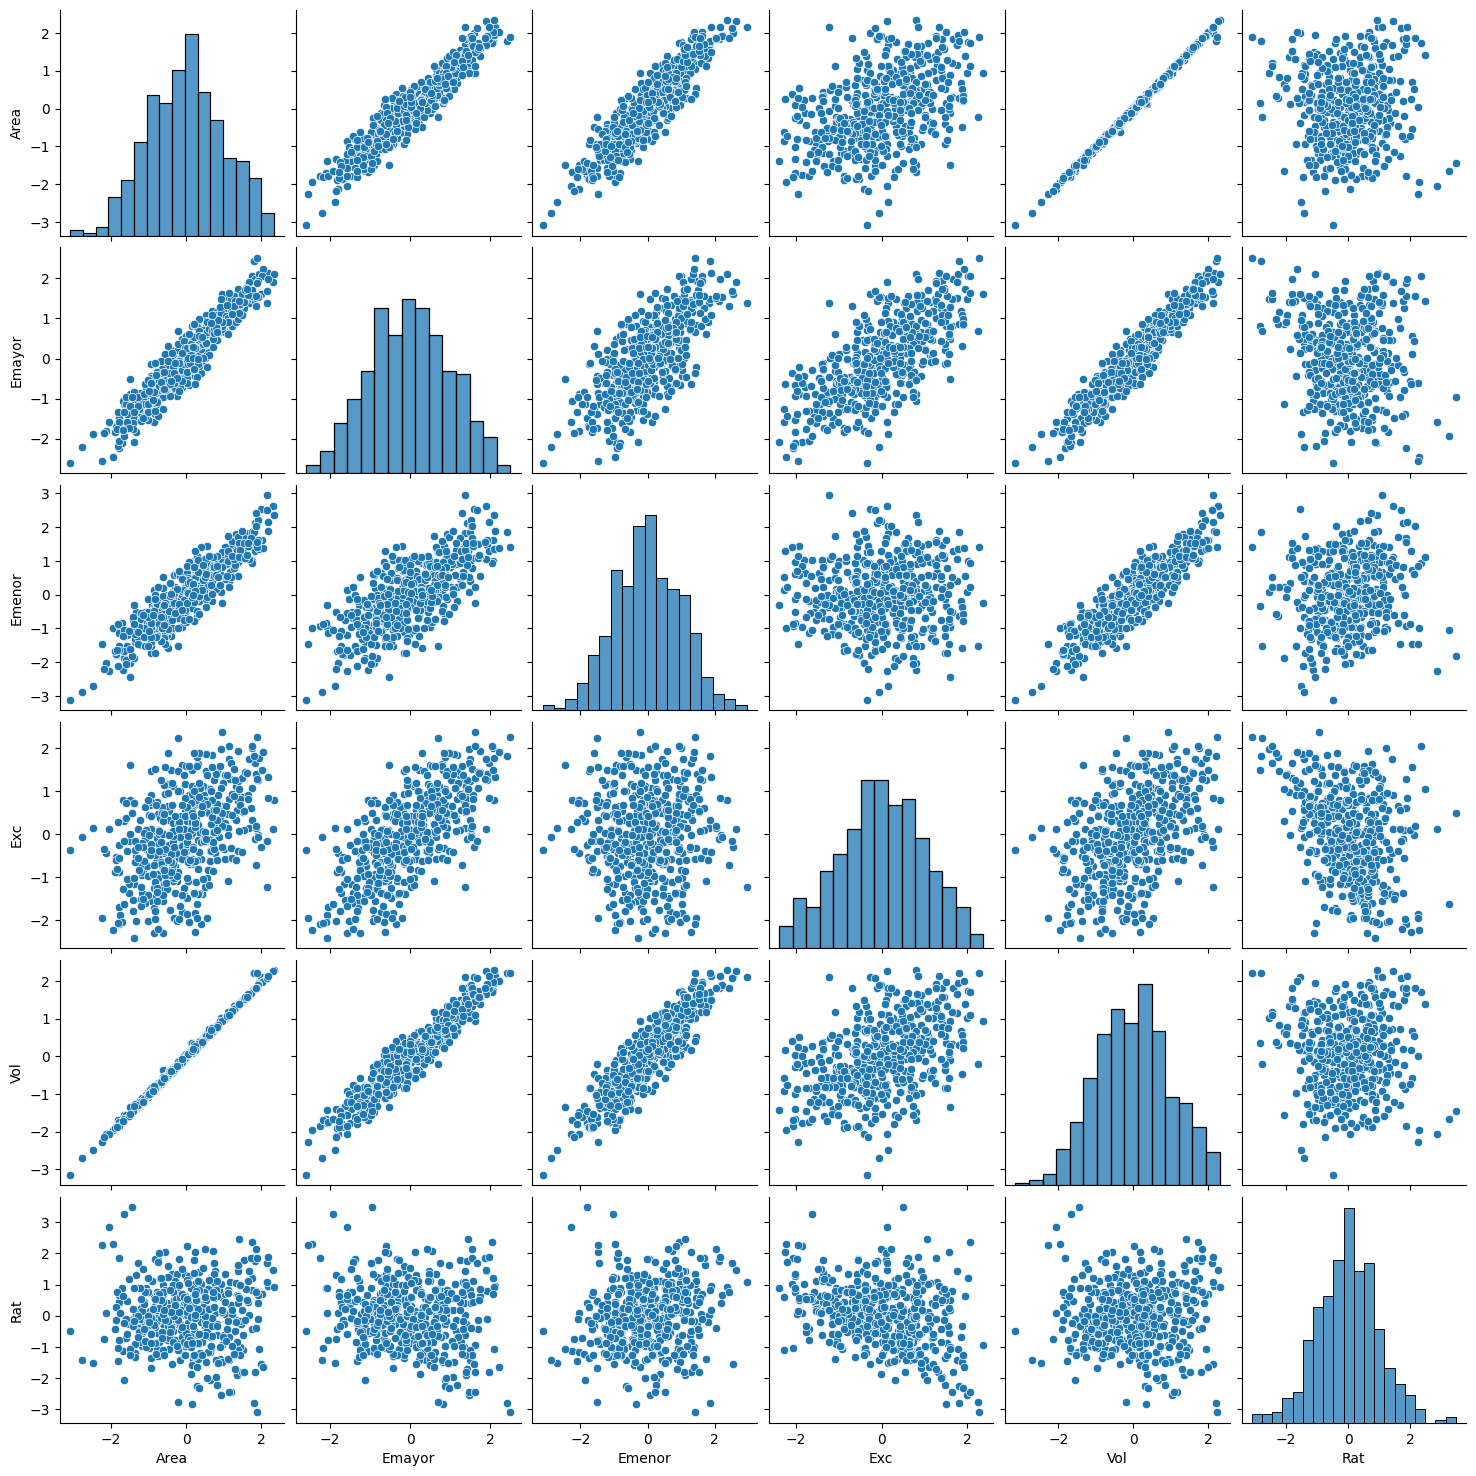

In [50]:
sns.pairplot(subset)
plt.show()

    b) `Vol` frente a resto (ex-`Perim`)

In [51]:
# features_reduced_set = features[:-1]
features_reduced_set = [f for f in features_names[:-1] if f!="Vol"]
features_reduced_set

['Area', 'Emayor', 'Emenor', 'Exc', 'Rat']

In [52]:

calls_reg = sm.ols(
    formula = "Vol~"+"+".join(features_reduced_set),
    data = data_pt_df[features_names[:-1]]
)
res_calls = calls_reg.fit()
res_calls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Vol   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.172e+05
Date:                Sun, 19 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:10:37   Log-Likelihood:                 1034.3
No. Observations:                 484   AIC:                            -2057.
Df Residuals:                     478   BIC:                            -2032.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.32e-14      0.001   1.01e-11      1.000      -0.003       0.003
Area           0.2623      0.032      8.266      0.000       0.200       0.325
Emayor         0.5843      0.037     15.757      0.000       0.511       0.657
Emenor         0.2399      0.022     10.940      0.000       0.197       0.283
Exc           -0.0796      0.019     -4.216      0.000      -0.117      -0.042
Rat           -0.0056      0.002     -3.710      0.000      -0.009      -0.003
==============================================================================
Omnibus:                       60.230   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.254
Skew:                           0.631   Prob(JB):                     8.68e-34
Kurtosis:                       5.440   Cond. No.                         61.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
vif = pd.DataFrame()
# subset = data_std_df.loc[:,[f for f in features_reduced_set if f!="Vol"]]
subset = data_pt_df.loc[:,[f for f in features_reduced_set if f!="Vol"]]
vif['VIF'] = [variance_inflation_factor(exog=subset.values, exog_idx=i) for i in range(subset.shape[1])]
vif['variable'] = subset.columns
vif

,VIF,variable
0,590.512865,Area
1,806.220940,Emayor
2,281.873031,Emenor
3,208.800715,Exc
4,1.349199,Rat


    c) `Area` frente a resto (ex-`Perim` y `Vol`)

In [54]:
features_names

['Area', 'Emayor', 'Emenor', 'Exc', 'Vol', 'Rat', 'Perim']

In [55]:
features_reduced_set = [f for f in features_names[:-1] if f not in ["Vol","Perim"]]
features_reduced_set

['Area', 'Emayor', 'Emenor', 'Exc', 'Rat']

In [56]:

# calls_reg = sm.ols(
#     formula = "Area~"+"+".join(features_reduced_set[1:]),
#     data = data_std_df[features_names[:-1]]
# )
# res_calls = calls_reg.fit()
# res_calls.summary()

calls_reg = sm.ols(
    formula = "Area~"+"+".join(features_reduced_set[1:]),
    data = data_pt_df[features_names[:-1]]
)
res_calls = calls_reg.fit()
res_calls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Area   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 7.059e+04
Date:                Sun, 19 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:12:57   Log-Likelihood:                 857.43
No. Observations:                 484   AIC:                            -1705.
Df Residuals:                     479   BIC:                            -1684.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -9.897e-15      0.002  -5.26e-12      1.000      -0.004       0.004
Emayor         0.7979      0.039     20.459      0.000       0.721       0.875
Emenor         0.3239      0.028     11.614      0.000       0.269       0.379
Exc           -0.1185      0.027     -4.450      0.000      -0.171      -0.066
Rat            0.0156      0.002      7.562      0.000       0.012       0.020
==============================================================================
Omnibus:                      495.679   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33934.957
Skew:                          -4.367   Prob(JB):                         0.00
Kurtosis:                      43.080   Cond. No.                         41.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
data_pt_df.head()

,Area,Emayor,Emenor,Exc,Vol,Rat,Perim
0,0.608440,0.492979,0.781415,-0.115940,0.629485,-0.340963,0.703810
1,-0.020462,0.451994,-0.502460,1.165714,0.054456,-0.963448,0.339250
2,-0.774619,-0.601617,-0.927118,0.094318,-0.821020,-1.020538,-0.856675
3,-0.099708,-0.023843,-0.115189,0.078558,-0.073601,-0.380375,0.016093
4,0.066763,0.362990,-0.363478,0.910629,0.097427,-0.564527,0.231255


In [57]:
# vif = pd.DataFrame()
# subset = data_std_df.loc[:,[f for f in features_reduced_set if f!="Area"]]
# vif['VIF'] = [variance_inflation_factor(exog=subset.values, exog_idx=i) for i in range(subset.shape[1])]
# vif['variable'] = subset.columns
# vif
vif = pd.DataFrame()
subset = data_pt_df.loc[:,[f for f in features_reduced_set if f!="Area"]]
vif['VIF'] = [variance_inflation_factor(exog=subset.values, exog_idx=i) for i in range(subset.shape[1])]
vif['variable'] = subset.columns
vif

,VIF,variable
0,430.248723,Emayor
1,219.936076,Emenor
2,200.512342,Exc
3,1.205312,Rat


    d) Análisis de Sensibilidad a la transformacion `StandardScaler`

¿Qué ocurre si no transformamos las variables numéricas?

In [59]:
%whos list

Variable               Type    Data/Info
----------------------------------------
features_names         list    n=7
features_reduced_set   list    n=5


In [60]:
right_formula = " + ".join(
    [fs for fs in features_names if fs not in ["Vol","Perim","Area"]]
)

num_subset = data.loc[:,[fs for fs in features_names if fs not in ["Vol","Perim"]]]

In [61]:
untransformed_ols = sm.ols(
    formula="Area ~ " + right_formula,
    data=num_subset
)

In [62]:
untransformed_result = untransformed_ols.fit()
untransformed_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Area   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     6971.
Date:                Sun, 19 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:16:55   Log-Likelihood:                -4800.0
No. Observations:                 484   AIC:                             9610.
Df Residuals:                     479   BIC:                             9631.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.397e+05   1.24e+04    -11.287      0.000   -1.64e+05   -1.15e+05
Emayor       208.1198      6.688     31.116      0.000     194.977     221.262
Emenor       345.5608     12.735     27.134      0.000     320.537     370.585
Exc         2326.4168   5299.010      0.439      0.661   -8085.760    1.27e+04
Rat         2.688e+04   4772.545      5.632      0.000    1.75e+04    3.63e+04
==============================================================================
Omnibus:                      139.239   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              558.735
Skew:                           1.242   Prob(JB):                    4.70e-122
Kurtosis:                       7.641   Cond. No.                     3.05e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Si analizamos el coeficiente de inflación de la varianza (`VIF`), se aprecia claramente que, de nuevo, `Area` puede ser redundante, incluso para datos sin transformar

In [63]:
num_subset.columns.tolist()

['Area', 'Emayor', 'Emenor', 'Exc', 'Rat']

In [64]:
vif = pd.DataFrame()
subset = data.loc[:,num_subset.columns.tolist()[1:]]
vif['VIF'] = [variance_inflation_factor(exog=subset.values, exog_idx=i) for i in range(subset.shape[1])]
vif['variable'] = subset.columns
vif

,VIF,variable
0,122.345262,Emayor
1,162.630774,Emenor
2,735.256269,Exc
3,780.855665,Rat


Que muestra la importancia del `scaler` de cara a tener `VIF`s comparables. 

Retendremos para el resto del entrenamiento pues, las siguientes variables:

+ `Emayor`
+ `Emenor`
+ `Exc`
+ `Rat`

In [65]:
features_reduced_set = [f for f in features_names if f not in ["Vol","Area","Perim"]]
features_reduced_set

['Emayor', 'Emenor', 'Exc', 'Rat']

In [66]:
%whos DataFrame

Variable     Type         Data/Info
-----------------------------------
corr         DataFrame                Area    Emayo<...>88656 -0.093764  1.000000
data         DataFrame             Area      Emayor<...>n\n[484 rows x 8 columns]
data_c       DataFrame             Area      Emayor<...>n\n[720 rows x 8 columns]
data_pt_df   DataFrame             Area    Emayor  <...>n\n[484 rows x 7 columns]
num_subset   DataFrame             Area      Emayor<...>n\n[484 rows x 5 columns]
subset       DataFrame             Emayor      Emen<...>n\n[484 rows x 4 columns]
vif          DataFrame              VIF variable\n0<...>c\n3  780.855665      Rat


##### 3.1.2 Separabilidad

In [67]:
import plotly.express as px

In [68]:
data.columns

Index(['Area', 'Emayor', 'Emenor', 'Exc', 'Vol', 'Rat', 'Perim', 'Clase'], dtype='object')

In [85]:
data[["Emayor","Exc","Clase"]].head()

,Emayor,Exc,Clase
0,465.179920,1.786964,B
1,460.142902,1.870360,B
2,352.441365,1.802965,A
3,406.690687,1.801805,A
4,449.454581,1.856043,A


In [70]:
data[features_reduced_set+["Clase"]]

,Emayor,Emenor,Exc,Rat,Clase
0,465.179920,287.015714,1.786964,1.686193,B
1,460.142902,226.581322,1.870360,1.651213,B
2,352.441365,210.064210,1.802965,1.647719,A
3,406.690687,243.032436,1.801805,1.684130,A
4,449.454581,232.325506,1.856043,1.674236,A
...,...,...,...,...,...
713,268.125361,199.635401,1.667556,1.732384,A
715,350.127874,315.719520,1.432307,1.785887,A
716,317.172325,222.753453,1.711871,1.714254,A
717,440.833740,245.381880,1.830760,1.657162,B


In [97]:
# fig = px.scatter(data[["Exc","Rat","Clase"]], x="Rat", y="Exc", 
#                     color="Clase",
#                     size="Exc",
#                     size_max=5
#     )

# fig.show()

fig = px.scatter_3d(data[["Emenor","Rat","Exc","Clase"]], x="Emenor", y="Rat", z="Exc", 
                    color="Clase",
                    size="Exc",
                    opacity=0.8,
                    size_max=8
    )
fig.show()

Hay bastantes posibilidades de separabilidad aunque la frontera no sea trivial (plana). En el espacio `EMenor`-`Rat`-`Exc` se distinguen además dos outliers, que difícilmente van a ser clasificables por cualquier modelo.

In [74]:
data_pt_df["Clase"] = data.iloc[:,-1]
data_pt_df.shape

(484, 8)

In [75]:
data_pt_df.head()

,Area,Emayor,Emenor,Exc,Vol,Rat,Perim,Clase
0,0.608440,0.492979,0.781415,-0.115940,0.629485,-0.340963,0.703810,B
1,-0.020462,0.451994,-0.502460,1.165714,0.054456,-0.963448,0.339250,B
2,-0.774619,-0.601617,-0.927118,0.094318,-0.821020,-1.020538,-0.856675,A
3,-0.099708,-0.023843,-0.115189,0.078558,-0.073601,-0.380375,0.016093,A
4,0.066763,0.362990,-0.363478,0.910629,0.097427,-0.564527,0.231255,A


In [77]:
fig = px.scatter_3d(data_pt_df[features_reduced_set+["Clase"]], x="Emenor", y="Rat", z="Exc", 
                    color="Clase"
    )
fig.show()

##### 3.1.3 Separabilidad II

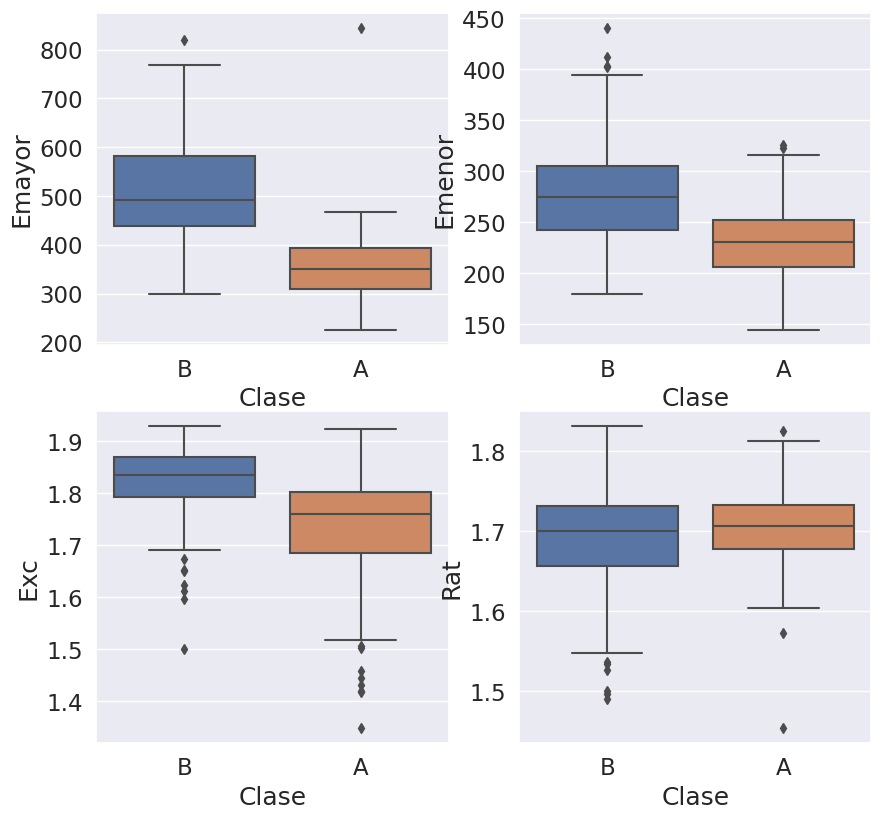

In [84]:
sns.set(style="darkgrid", font_scale=1.5)
plt.subplots(figsize = (10,25))

for i,feature in enumerate(features_reduced_set):
    plt.subplot(5,2,i+1)
    sns.boxplot(x='Clase', y=feature, data=data)
    
plt.show()


### 4 Modelado

#### 4.1 Adding n Cluster Categories as a Features to n-Classification Problem

In [163]:
%load_ext autoreload
%autoreload 2

from bb_trainer_handler import bb_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
import sklearn
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [99]:
print(f"#Samples with Filtered NaNs: {data.shape[0]}")
print(f"#Samples with Imputed NaNs: {data_c.shape[0]}")

#Samples with Filtered NaNs: 484
#Samples with Imputed NaNs: 720


In [103]:
# Complete Data
data_dict = {}
data_dict["data"] = data_c.iloc[:,:-1]
data_dict["target"] = data_c.iloc[:,-1].map({"A": 0, "B": 1})

In [250]:
X = data_dict["data"]
X

,Area,Emayor,Emenor,Exc,Vol,Rat,Perim
0,100928.0,465.179920,287.015714,1.786964,105549.0,1.686193,1310.510
1,77622.0,460.142902,226.581322,1.870360,82990.0,1.651213,1205.141
2,57612.0,352.441365,210.064210,1.802965,58810.0,1.647719,934.684
3,75166.0,406.690687,243.032436,1.801805,78789.0,1.684130,1121.786
4,80437.0,449.454581,232.325506,1.856043,84460.0,1.674236,1176.305
...,...,...,...,...,...,...,...
715,86545.0,350.127874,315.719520,1.432307,87512.0,1.785887,1070.062
716,55114.0,317.172325,222.753453,1.711871,56849.0,1.714254,909.604
717,83800.0,440.833740,245.381880,1.830760,86346.0,1.657162,1170.091
718,84539.0,441.528890,248.374317,1.826775,87728.0,1.687577,1169.983


In [108]:
data_c.info() # Working With the Full Set and Imputing (Strategy: Median)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Area    681 non-null    float64
 1   Emayor  686 non-null    float64
 2   Emenor  683 non-null    float64
 3   Exc     676 non-null    float64
 4   Vol     677 non-null    float64
 5   Rat     680 non-null    float64
 6   Perim   673 non-null    float64
 7   Clase   720 non-null    object 
dtypes: float64(7), object(1)
memory usage: 45.1+ KB


In [112]:
""" 
Variables Mixtas, Requieren Transfomers Mixtos -> ColumnTransformer() es capaz de combinar diferentes
transformaciones de una manera heterogenea y muy flexible
"""
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer # El filtrado de NAs hace la serie excesivamente  
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler

In [109]:
features_reduced_set.remove("Emenor")

In [110]:
print(f"Original Feature Names: {features_names}")
print(f"Reduced Feature Names: {features_reduced_set}")

Original Feature Names: ['Area', 'Emayor', 'Emenor', 'Exc', 'Vol', 'Rat', 'Perim']
Reduced Feature Names: ['Emayor', 'Exc', 'Rat']


In [113]:
impute_median = SimpleImputer(missing_values=np.nan, strategy="median")

In [153]:
ct = ColumnTransformer(
    [   
        ("discards", "drop", ["Area","Vol","Perim","Emenor"]),
        ("imputer", impute_median, features_reduced_set)  
    ]
)


In [154]:
features_names

['Area', 'Emayor', 'Emenor', 'Exc', 'Vol', 'Rat', 'Perim']

In [158]:

bb = bb_dataset(data_dict).scale_transform(ct,features_reduced_set) # Instantiation with Original Untransformed Data

In [156]:
bb.X_train.head()

,Emayor,Exc,Rat
0,336.584070,1.735759,1.700287
1,352.011403,1.701653,1.703440
2,408.189922,1.724403,1.713855
3,368.786307,1.800063,1.663845
4,494.055192,1.849103,1.614175


In [159]:
bb.classify()

Accuracy: 0.8287037037037037


In [157]:
bb.clustering(output="replace").classify()

Accuracy: 0.8287037037037037


In [167]:
bb = bb_dataset(data_dict)
bb.scale_transform(ct, features_reduced_set).clustering().classify(SVC())

Accuracy: 0.8240740740740741


#### 4.2 <del><u>Baseline Modeling:</u> mediante **Pipelines**</del>

In [92]:

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
#from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree

# Construct some pipelines
pipe_lr = Pipeline([('scl', ct),
			# ('pca', PCA(n_components=3)),
			('clf', LogisticRegression(random_state=42))])

pipe_svm = Pipeline([('scl', ct),
			# ('pca', PCA(n_components=3)),
			('clf', svm.SVC(random_state=42))])
			
pipe_dt = Pipeline([('scl', ct),
			# ('pca', PCA(n_components=3)),
			('clf', tree.DecisionTreeClassifier(random_state=42))])

# List of pipelines for ease of iteration
pipelines = [pipe_lr, pipe_svm, pipe_dt]
			
# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression', 1: 'Support Vector Machine', 2: 'Decision Tree'}

# Fit the pipelines
for pipe in pipelines:
	bb = bb_dataset(data_dict)
	pipe.fit(X_train, y_train)

# Compare accuracies
for idx, val in enumerate(pipelines):
	print('%s pipeline test accuracy: %.3f' % (pipe_dict[idx], val.score(X_test, y_test)))

# Identify the most accurate model on test data
best_acc = 0.0
best_clf = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
	if val.score(X_test, y_test) > best_acc:
		best_acc = val.score(X_test, y_test)
		best_pipe = val
		best_clf = idx
print('Classifier with best accuracy: %s' % pipe_dict[best_clf])

# Save pipeline to file
""" joblib.dump(best_pipe, 'best_pipeline.pkl', compress=1)
print('Saved %s pipeline to file' % pipe_dict[best_clf]) """

Logistic Regression pipeline test accuracy: 0.844
Support Vector Machine pipeline test accuracy: 0.856
Decision Tree pipeline test accuracy: 0.806
Classifier with best accuracy: Support Vector Machine


" joblib.dump(best_pipe, 'best_pipeline.pkl', compress=1)\nprint('Saved %s pipeline to file' % pipe_dict[best_clf]) "

La SVM para clasificacion como estimador debil sin tuneo de hiperparámetros: da el mejor resultado por lo que podría ser también un buen candidato para clasificación por agregación de modelos (bien sea `bagging` o `boosting`). También se puede combinar diferentes modelos mediante `stacking` (modelos distintos con bootstrap de las muestras)

In [93]:
best_pipe # Esquema detallado del mejor estimador elemental con preproceso previo. PCA() no parece tener un efecto significativo sobre les resultados.

Pipeline(steps=[('scl',
                 ColumnTransformer(transformers=[('discards', 'drop',
                                                  ['Area', 'Vol', 'Perim']),
                                                 ('imputer', SimpleImputer(),
                                                  ['Emayor', 'Emenor', 'Exc',
                                                   'Rat'])])),
                ('pca', PCA(n_components=3)), ('clf', SVC(random_state=42))])

Es importante reseñar que los métodos que actúan sobre el Pipe para estimar modelo `.fit`, aplican `fit_transform()` para el escalado de variables originales, mientras que los métodos para predecir (`.predict()`,`.score()`, etc) únicamente transforman vía `.transform()`

![Esquema de métodos con Pipelines de `sklearn`](https://i.stack.imgur.com/uR1Wt.png)

#### 4.3 <u>Ensembles</u>:

##### 4.3.1 Bootstrap Aggregation (Bagging): `Random Forest`

Dado que un estimador débil como el árbol de decisión ha dado unos resultados insuficientes aunque alentadores, podemos estudiar si la agregación (vía `Boosting`, `Bagging` o `Stacking`) de éstos supone una mejora en los resultados para el conjunto de test. Empezamos por bosques aleatorios, dado que su implementación es la más directa

_a) Direct Search_

In [591]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
run_gs = True

# MyBlueBerry Instantiation (imputing, dropping and no-scaling and adding Kmeans cluster as features)
bb = bb_dataset(data_dict).scale_transform(ct,features_reduced_set)
bb.clustering()

if run_gs:
    parameter_grid = {
                 'max_depth' : [4, 5, 6],
                 'n_estimators': [10, 20, 50,],
                 'max_features': ['sqrt'],
                 'min_samples_split': [3, 10, 20],
                 'min_samples_leaf': [1, 2, 3, 4]
    }
    
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(
        forest,
        scoring='accuracy',
        param_grid=parameter_grid,
        cv=cross_validation,
        verbose=1
    )

    bb.gs_CV(grid_search)
    RF_model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 2, 
                  'min_samples_split': 40, 'max_features': 'sqrt', 'max_depth': 5}
    
    RF_model = RandomForestClassifier(**parameters)
    bb.classify(model=model)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best score: 0.8611683168316832
Best parameters: {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 50}


In [593]:
parameters

{'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 50}

In [555]:
# Refitting
model = RandomForestClassifier(**grid_search.best_params_, random_state=42)
RF_mdl_fitted = bb_dataset(data_dict).scale_transform(ct, features_reduced_set).clustering().classify(model) 

Accuracy: 0.8425925925925926


In [558]:
RF_mdl_fitted.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

**<u>Evaluation Metrics</u>**

Análisis más detallado de métricas dado que por ser un problema de clasificación binario se puede hacer más extenso.

In [559]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
bb_scl = bb_dataset(data_dict).scale_transform(ct, features_reduced_set).clustering() 

Por ser un problema de clasificación binaria, es crucial el uso de la ROC para optimizar el gap entre tpr y fpr y de esta manera ser más ajustado en la clasificación.

In [495]:
def roc_auc_results(actual, predicted):
    fpr, tpr, threshold = roc_curve(actual, predicted, drop_intermediate=False)
    roc_auc = roc_auc_score(actual, predicted)

    plt.title('Curva ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Ratio verdaderos positivos')
    plt.xlabel('Ratios falsos positivos')
    plt.show()

    print(f"Area Under the Curve (the Closer to 1, the Better): {100*roc_auc:.1f}%")
    optimal_idx = np.argmax(tpr - fpr)
    print("Threshold value is:", threshold[optimal_idx])
    return threshold[optimal_idx]
    

* Cálculo de métricas en <u>conjunto de entrenamiento</u>:

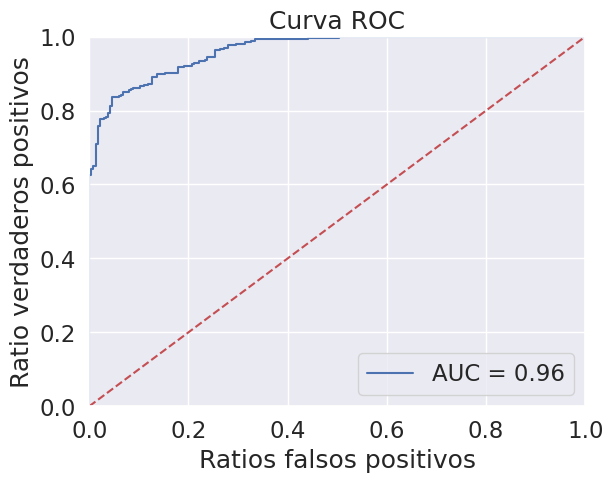

Area Under the Curve (the Closer to 1, the Better): 96.3%
Threshold value is: 0.6368098799563993


In [564]:
# ROC Results (for determining optimal treshold for labelling)
RF_th_proba = roc_auc_results(bb_scl.y_train, RF_mdl_fitted.predict_proba(bb_scl.X_train)[:,1])

In [566]:
# Raw Confusion Matrix
pred_train = RF_mdl_fitted.predict(bb_scl.X_train)
confusion_matrix(bb_scl.y_train, pred_train)

array([[210,  26],
       [ 35, 233]])

In [567]:
# Optimized under the ROC for the Train Set
pred_opt_train = np.where(
    RF_mdl_fitted.predict_proba(bb_scl.X_train)[:,1]>RF_th_proba,
    1,
    0
)
confusion_matrix(bb_scl.y_train, pred_opt_train)

array([[225,  11],
       [ 45, 223]])

In [572]:
raw_acc = accuracy_score(bb_scl.y_train, pred_train) # Treshold 0.5
opt_acc = accuracy_score(bb_scl.y_train, pred_opt_train) # ROC optimized Treshold
print(f"acc raw {100*raw_acc:.0f}%")
print(f"acc ROC {100*opt_acc:.0f}%")

acc raw 88%
acc ROC 89%


In [576]:
# t* clf Report
print(classification_report(bb_scl.y_train, pred_opt_train))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       236
           1       0.95      0.83      0.89       268

    accuracy                           0.89       504
   macro avg       0.89      0.89      0.89       504
weighted avg       0.90      0.89      0.89       504



In [577]:
# raw
print(classification_report(bb_scl.y_train, pred_train))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       236
           1       0.90      0.87      0.88       268

    accuracy                           0.88       504
   macro avg       0.88      0.88      0.88       504
weighted avg       0.88      0.88      0.88       504



* Cálculo de métricas en <u>conjunto de test</u>:

In [586]:
# Raw Metrics Report
pred_test = RF_mdl_fitted.predict(bb_scl.X_test)
print(f"{confusion_matrix(bb_scl.y_test, pred_test)}\n")

raw_acc = accuracy_score(bb_scl.y_test, pred_test) # Treshold 0.5
print(f"acc raw {100*raw_acc:.0f}%\n")

print(classification_report(bb_scl.y_test, pred_test))

[[100  22]
 [ 12  82]]

acc raw 84%

              precision    recall  f1-score   support

           0       0.89      0.82      0.85       122
           1       0.79      0.87      0.83        94

    accuracy                           0.84       216
   macro avg       0.84      0.85      0.84       216
weighted avg       0.85      0.84      0.84       216



In [588]:
RF_mdl_fitted.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

_b) Random Search_

In [288]:
from sklearn.model_selection import RandomizedSearchCV
from  scipy.stats import uniform, truncnorm, randint # Para generar la nube de params aleatoria a seleccionar

In [289]:
# Resetting BlueBerry DataSet Object (adding KMeans cluster labels)
bb = bb_dataset(data_dict).scale_transform(ct, features_reduced_set).clustering()

In [290]:

param_distributions = [
    {
        'max_depth' : randint(5,20),
        'n_estimators': randint(10,200),        
        'min_samples_split': uniform(0.01,0.199),
        'min_samples_leaf': randint(1,10)
    },    
]

rf_model = RandomForestClassifier()
clf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=50,
    cv=StratifiedKFold(),  # Validacion Estratificada (preservando proporción de clases) basada en 5 Folds
    scoring="accuracy",
    refit=True,
    random_state=42
)

rndsearch_RF_mdl = bb.gs_CV(clf)

In [291]:
rndsearch_RF_mdl.best_estimator_

RandomForestClassifier(max_depth=13, min_samples_leaf=2,
                       min_samples_split=0.0866978840054433, n_estimators=99)

In [292]:
rndsearch_RF_mdl.best_score_

0.8591683168316833

In [ ]:
""" from pprint import pprint
pprint(model.best_estimator_.get_params()) """

In [294]:
best_RFmodel = rndsearch_RF_mdl.best_estimator_
train_score = best_RFmodel.score(bb_scl.X_train, bb_scl.y_train)
test_score = best_RFmodel.score(bb_scl.X_test, bb_scl.y_test)  

In [295]:
print(f"Score en Conjunto Entrenamiento: {100*train_score:.1f}%")
print(f"Score en Conjunto Test: {100*test_score:.1f}%")

Score en Conjunto Entrenamiento: 87.7%
Score en Conjunto Test: 84.3%


In [296]:
np.ceil(0.0866978840054433*bb_scl.X_train.shape[0])

44.0

In [298]:
bb_scl.X_test

,Emayor,Exc,Rat,km_clust
0,532.084130,1.765407,1.770644,1
1,396.705912,1.733205,1.745435,0
2,558.058751,1.823355,1.677765,1
3,594.759221,1.806766,1.704686,1
4,429.090409,1.809314,1.704841,0
...,...,...,...,...
211,511.472036,1.821574,1.624760,1
212,489.454217,1.829377,1.741610,1
213,388.454723,1.815663,1.746130,0
214,473.575846,1.853316,1.673231,1


In [303]:
# GS Refinements based on Randomized Search CV
fine_tuning_gs_params = {
    "max_depth": [13,14,15],            
    "min_samples_leaf": [2,3,4,5],     
    "min_samples_split": [45,50,55], 
    "n_estimators": [95,100,105]
}

fine_tuned_forest = RandomForestClassifier()

grid_search = GridSearchCV(
        fine_tuned_forest,
        scoring='accuracy',
        param_grid=fine_tuning_gs_params,
        cv=StratifiedKFold(),
        verbose=1,
        refit=True,
        n_jobs=-1
)

bb_scl.gs_CV(grid_search)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [13, 14, 15],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [45, 50, 55],
                         'n_estimators': [95, 100, 105]},
             scoring='accuracy', verbose=1)

In [304]:
grid_search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 14,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 55,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 105,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [305]:
grid_search.best_score_

0.857168316831683

**Conclusiones**: La mejora por refinamiento del la busqueda aleatorizada es marginal y no se traslada a una mejora sustancial
en conjunto de test.

In [306]:
pred_test = grid_search.best_estimator_.predict(bb_scl.X_test)

from sklearn.metrics import classification_report
print(classification_report(bb_scl.y_test, pred_test))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85       122
           1       0.78      0.87      0.82        94

    accuracy                           0.84       216
   macro avg       0.84      0.84      0.84       216
weighted avg       0.84      0.84      0.84       216



#### 4.3.2 Otros Bagging: BaggingClassifier de `LogisticRegression()` y `SVC()`

Vamos a tratar de mejorar nuestros resultados mediante conjuntos de estimadores débiles distintos a los árboles de decisión.

La evaluación `baseline` que hemos hecho de modelos simples sin tuneo de hiperparámetros nos da idea que un `ensemble` basado en Máquinas Vector Soporte para Clasificación `SVC` podría ser una buena elección

##### Basadas en `SVC`

<u>*Primer Ansatz*</u>

Estimacion Naive sin tuneo de hiperparametros, basándose en el mejor estimador débil de los baseline

In [309]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(
	base_estimator=SVC()
)

# Hay que redefinir el Pipe para Bagging (no admite directamente el Pipeline de un modelo simple)
""" bag_pipe = Pipeline([('scl', ct),			
			('clf', bag_clf)])

bag_pipe.fit(X_train, y_train)
bag_pipe.score(X_test,y_test) """

bb_scl.classify(model=bag_clf)

Accuracy: 0.8240740740740741


BaggingClassifier(base_estimator=SVC())

In [ ]:
bag_clf.predict_proba(bb_scl.X_test)[:,1]

In [ ]:
confusion_matrix(bb_scl.y_test, bag_clf.predict(bb_scl.X_test))

<u>*Random Search*</u>

In [318]:
param_distributions = [
    {
        'n_estimators': randint(10,200),
        'max_samples': uniform(0.01, 0.25)
    }    
]

In [319]:
rs_bag = RandomizedSearchCV(
    estimator=BaggingClassifier(SVC()),
    param_distributions=param_distributions,        
    n_iter=50,        
    random_state=42,
    verbose=3,
    refit=True,
    n_jobs=-1
)

In [ ]:
bb_scl.gs_CV(rs_bag)

In [321]:
rs_bag.best_score_

0.8571485148514851

In [322]:
rs_bag.best_estimator_.score(bb_scl.X_test,bb_scl.y_test)

0.8425925925925926

In [323]:
rs_bag.best_params_

{'max_samples': 0.19884035257941313, 'n_estimators': 143}

#### 4.3.3. Boosting: AdaBoost de `Sklearn`

In [325]:
from sklearn.ensemble import AdaBoostClassifier

boost_clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=8),        
)

In [329]:
bb_scl.classify(model=boost_clf)

Accuracy: 0.8472222222222222


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=8))

In [330]:
boost_clf.score(bb_scl.X_train, bb_scl.y_train)

1.0

In [331]:
boost_clf.score(bb_scl.X_test, bb_scl.y_test)

0.8472222222222222

* <u>Randomized Search</u>

In [332]:
params = {
 #'max_depth':randint(4,10),
 'learning_rate': uniform(0.05,0.1),
 'n_estimators':[150,175,200]
}

rsearch = RandomizedSearchCV(
    estimator = boost_clf,
    param_distributions=params,
    cv = StratifiedKFold(n_splits=5),
    verbose=3,
    n_jobs=-1
)

bb_scl.gs_CV(rsearch)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 5/5] END learning_rate=0.14305605174483027, n_estimators=200;, score=0.750 total time=   0.1s
[CV 2/5] END learning_rate=0.14305605174483027, n_estimators=200;, score=0.832 total time=   0.1s
[CV 1/5] END learning_rate=0.12136151799386732, n_estimators=150;, score=0.772 total time=   0.1s
[CV 1/5] END learning_rate=0.14305605174483027, n_estimators=200;, score=0.812 total time=   0.3s
[CV 2/5] END learning_rate=0.12136151799386732, n_estimators=150;, score=0.802 total time=   0.4s
[CV 3/5] END learning_rate=0.14305605174483027, n_estimators=200;, score=0.861 total time=   0.4s
[CV 2/5] END learning_rate=0.12403602816224385, n_estimators=150;, score=0.802 total time=   0.1s
[CV 4/5] END learning_rate=0.12136151799386732, n_estimators=150;, score=0.792 total time=   0.3s
[CV 1/5] END learning_rate=0.11282420953141435, n_estimators=200;, score=0.792 total time=   0.0s
[CV 3/5] END learning_rate=0.12136151799386732, n_estimat

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=8)),
                   n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f95870f6610>,
                                        'n_estimators': [150, 175, 200]},
                   verbose=3)

In [333]:
rsearch.best_score_

0.8332277227722772

In [334]:
rsearch.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=8),
                   learning_rate=0.11466766567264254, n_estimators=175)

In [335]:
rsearch.best_estimator_.score(bb_scl.X_test, bb_scl.y_test)

0.8333333333333334

#### 4.3.4 <u>xgboost</u> de `dlmc`

In [457]:
import xgboost as xgb 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [458]:
dtrain_clf = xgb.DMatrix(bb_scl.X_train, bb_scl.y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(bb_scl.X_test, bb_scl.y_test, enable_categorical=True)

In [455]:
bb_scl.X_test

,Emayor,Exc,Rat,km_clust
0,532.084130,1.765407,1.770644,1
1,396.705912,1.733205,1.745435,0
2,558.058751,1.823355,1.677765,1
3,594.759221,1.806766,1.704686,1
4,429.090409,1.809314,1.704841,0
...,...,...,...,...
211,511.472036,1.821574,1.624760,1
212,489.454217,1.829377,1.741610,1
213,388.454723,1.815663,1.746130,0
214,473.575846,1.853316,1.673231,1


In [459]:
# Define hyperparameters (Vanilla Training)

params = {
    "objective": "binary:logistic", 
    "eval_metric": "auc"
}

n = 100

model = xgb.train(
   params=params,
   dtrain=dtrain_clf,
   num_boost_round=n,
)

In [367]:
model.predict(dtest_clf)
np.where(model.predict(dtest_clf)<0.5)

(array([  4,   8,   9,  12,  13,  14,  16,  17,  20,  24,  25,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  38,  40,  41,  44,  46,
         47,  48,  49,  50,  53,  57,  60,  62,  64,  66,  68,  69,  70,
         71,  72,  74,  75,  79,  80,  81,  82,  85,  86,  87,  92,  93,
         95,  96,  97,  98,  99, 101, 104, 105, 106, 108, 110, 111, 113,
        114, 115, 116, 117, 118, 119, 122, 123, 124, 126, 127, 129, 131,
        132, 133, 136, 141, 142, 145, 148, 149, 151, 152, 155, 156, 157,
        158, 160, 162, 165, 166, 168, 171, 172, 178, 181, 183, 185, 187,
        188, 191, 192, 193, 197, 199, 202, 204, 205, 206, 207, 208, 213,
        215]),)

In [460]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Accuracy on Train Set 
pred_train = np.round(model.predict(dtrain_clf))
accuracy_score(pred_train, bb_scl.y_train)


0.998015873015873

In [461]:
# Accuracy Score on Test Set (xgboost vanilla)
pred_test = np.round(model.predict(dtest_clf))
accuracy_score(pred_test, bb_scl.y_test)

0.8518518518518519

* Claro signo de *sobreparametrización* (el modelo memoriza pero no generaliza)

In [462]:
evals = [(dtest_clf, "validation"), (dtrain_clf, "train")]

model = xgb.train(
   params=params,
   dtrain=dtrain_clf,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10
)

[0]	validation-auc:0.91498	train-auc:0.96102
[10]	validation-auc:0.91441	train-auc:0.98836
[20]	validation-auc:0.91289	train-auc:0.99663
[30]	validation-auc:0.91550	train-auc:0.99911
[40]	validation-auc:0.91494	train-auc:0.99983
[50]	validation-auc:0.91380	train-auc:0.99998
[60]	validation-auc:0.91197	train-auc:0.99998
[70]	validation-auc:0.91171	train-auc:0.99998
[80]	validation-auc:0.91066	train-auc:0.99998
[90]	validation-auc:0.90857	train-auc:0.99998
[99]	validation-auc:0.90726	train-auc:0.99998


Not Bad :)

* Incorporando _Early Stopping_

In [463]:
n = 10000

model = xgb.train(
   params=params,
   dtrain=dtrain_clf,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10,
   early_stopping_rounds=25
)

[0]	validation-auc:0.91498	train-auc:0.96102
[10]	validation-auc:0.91441	train-auc:0.98836
[20]	validation-auc:0.91289	train-auc:0.99663
[30]	validation-auc:0.91550	train-auc:0.99911
[40]	validation-auc:0.91494	train-auc:0.99983
[50]	validation-auc:0.91380	train-auc:0.99998
[60]	validation-auc:0.91197	train-auc:0.99998
[70]	validation-auc:0.91171	train-auc:0.99998
[72]	validation-auc:0.91162	train-auc:0.99998


##### Cross-Validated `XGBoostClassifier` (vanilla)

In [404]:
params = {
    "objective": "binary:logistic"
}

n = 10000


results = xgb.cv(
   params, 
   dtrain_clf,
   num_boost_round=n,
   nfold=5,
   metrics=["auc","logloss"],
   early_stopping_rounds=100
)

In [420]:
results.head()

,train-auc-mean,train-auc-std,train-logloss-mean,train-logloss-std,test-auc-mean,test-auc-std,test-logloss-mean,test-logloss-std
0,0.956278,0.006120,0.526503,0.006842,0.896205,0.037334,0.559805,0.018330
1,0.965610,0.005518,0.428767,0.007925,0.908232,0.031879,0.485082,0.027025
2,0.969866,0.006247,0.362531,0.010700,0.905335,0.034900,0.445411,0.036905
3,0.976177,0.005805,0.315230,0.011542,0.903413,0.033735,0.422508,0.045842
4,0.981399,0.003893,0.278536,0.012464,0.899999,0.035785,0.412505,0.052757


In [419]:
max_auc = 100*results["test-auc-mean"].max()
print(f"Max AUC for CV xgboost (Vanilla): {max_auc:.0f}%")

Max AUX for CV xgboost (Vanilla): 91%


### 5 Optuned models

#### 5.1 Load Best Params for `xgboost` 

In [421]:
import yaml

PARAM_FILE = "./xgb_optuned_params.yaml"

with open(PARAM_FILE,"r") as param_file:
    params = yaml.safe_load(param_file)

In [423]:
params["params1"]

{'booster': 'gblinear',
 'lambda': 3.47396818730749e-08,
 'alpha': 6.623632354652557e-05}

In [426]:
params_common = {
    "objective": "binary:logistic", 
    "eval_metric": "auc"
}

params_common.update(params["params1"])


' model = xgb.train(\n   params=params,\n   dtrain=dtrain_clf,\n   num_boost_round=n,\n) '

In [498]:
params_common

{'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'booster': 'gblinear',
 'lambda': 3.47396818730749e-08,
 'alpha': 6.623632354652557e-05}

#### 5.2 Refitting

In [499]:
n = 10000

evals = [(dtest_clf, "validation"), (dtrain_clf, "train")]

model = xgb.train(
   params=params_common,
   dtrain=dtrain_clf,
   num_boost_round=n,
   evals=evals,
   verbose_eval=100
)

[0]	validation-auc:0.92457	train-auc:0.91799
[100]	validation-auc:0.92614	train-auc:0.91965
[200]	validation-auc:0.92597	train-auc:0.91965
[300]	validation-auc:0.92588	train-auc:0.91974
[400]	validation-auc:0.92597	train-auc:0.91979
[500]	validation-auc:0.92597	train-auc:0.91987
[600]	validation-auc:0.92632	train-auc:0.91979
[700]	validation-auc:0.92632	train-auc:0.91987
[800]	validation-auc:0.92614	train-auc:0.91982
[900]	validation-auc:0.92605	train-auc:0.91981
[1000]	validation-auc:0.92588	train-auc:0.91987
[1100]	validation-auc:0.92579	train-auc:0.91987
[1200]	validation-auc:0.92588	train-auc:0.91981
[1300]	validation-auc:0.92588	train-auc:0.91978
[1400]	validation-auc:0.92588	train-auc:0.91981
[1500]	validation-auc:0.92571	train-auc:0.91973
[1600]	validation-auc:0.92571	train-auc:0.91973
[1700]	validation-auc:0.92579	train-auc:0.91978
[1800]	validation-auc:0.92579	train-auc:0.91973
[1900]	validation-auc:0.92571	train-auc:0.91976
[2000]	validation-auc:0.92553	train-auc:0.91971
[210

In [442]:
dtrain_clf.num_row()

504

In [504]:
pred_proba_test = model.predict(dtest_clf)
pred_proba_train = model.predict(dtrain_clf)

In [505]:
# Train AUC Score
roc_auc_score(bb_scl.y_train, pred_proba_train)

0.9191753098912219

In [508]:
# Test AUC Score
roc_auc_score(bb_scl.y_test,pred_proba_test)

0.9256191140565051

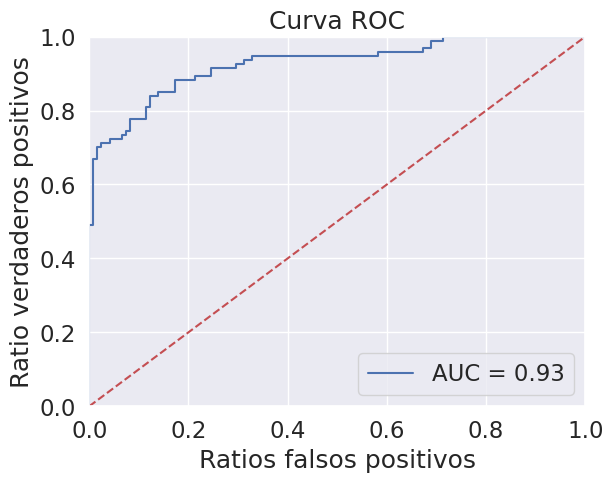

Area Under the Curve (the Closer to 1, the Better): 92.6%
Threshold value is: 0.50545263


In [509]:
# Computing Best Treshold for Labelling
th_proba_xgb = roc_auc_results(bb_scl.y_test, pred_proba_test)

In [514]:
pred_test = np.where(model.predict(dtest_clf)>th_proba_xgb,1,0)

#### 5.3 Metrics Comparison with Optimized Random Search

* Optuned `xgboost`

In [551]:
pred_test = np.where(model.predict(dtest_clf)>th_proba_xgb,1,0)

print(f"acc: {100*accuracy_score(bb_scl.y_test, pred_test):.0f}% \n")
print(classification_report(bb_scl.y_test, pred_test))

confusion_matrix(bb_scl.y_test, pred_test)

acc: 86% 

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       122
           1       0.84      0.83      0.83        94

    accuracy                           0.86       216
   macro avg       0.85      0.85      0.85       216
weighted avg       0.86      0.86      0.86       216



array([[107,  15],
       [ 16,  78]])

* Sklearn Optimized `RandomForest()` 

In [550]:
print(f"acc: {100*accuracy_score(bb_scl.y_test, RF_pred_test_calculated):.0f}% \n")
print(classification_report(bb_scl.y_test, RF_pred_test_calculated))

confusion_matrix(bb_scl.y_test, RF_pred_test_calculated)

acc: 87% 

              precision    recall  f1-score   support

           0       0.88      0.89      0.89       122
           1       0.86      0.84      0.85        94

    accuracy                           0.87       216
   macro avg       0.87      0.87      0.87       216
weighted avg       0.87      0.87      0.87       216



array([[109,  13],
       [ 15,  79]])

In [553]:
RF_mdl_fitted.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 14,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 55,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 105,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

#### 5.4 Load Optuned Params for `RandomForest()` 

In [594]:
import yaml

PARAM_FILE = "./optuned_params.yaml"

with open(PARAM_FILE,"r") as param_file:
    params = yaml.safe_load(param_file)


In [596]:
params["params_optuna_rf"]

{'max_depth': 18,
 'n_estimators': 69,
 'min_samples_split': 29,
 'min_samples_leaf': 2}

In [613]:
best_bag_clf = RandomForestClassifier(**params["params_optuna_rf"], random_state=42)
best_bag_clf.fit(bb_scl.X_train, bb_scl.y_train)

RandomForestClassifier(max_depth=18, min_samples_leaf=2, min_samples_split=29,
                       n_estimators=69, random_state=42)

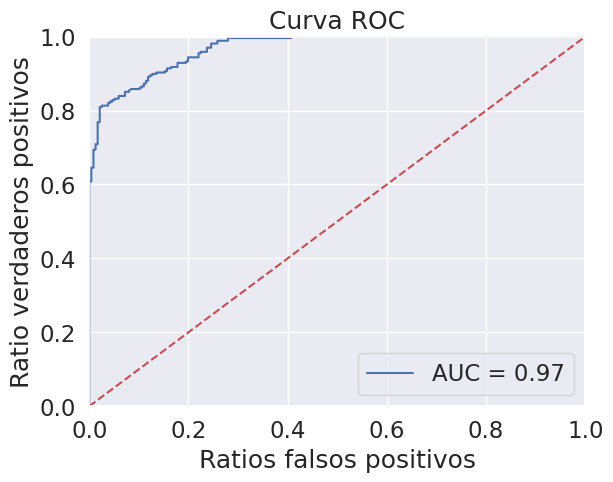

Area Under the Curve (the Closer to 1, the Better): 96.8%
Threshold value is: 0.670663520406963


In [614]:
RF_th_proba = roc_auc_results(bb_scl.y_train,best_bag_clf.predict_proba(bb_scl.X_train)[:,1])

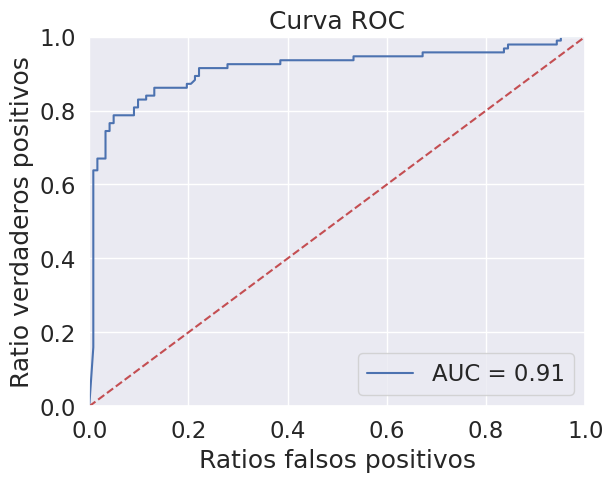

Area Under the Curve (the Closer to 1, the Better): 91.3%
Threshold value is: 0.6643128507048501


0.6643128507048501

In [615]:
roc_auc_results(bb_scl.y_test,best_bag_clf.predict_proba(bb_scl.X_test)[:,1])

In [620]:
# Opt Metrics Report (t* on Train Set)
pred_opt_test = np.where(best_bag_clf.predict_proba(bb_scl.X_test)[:,1]>RF_th_proba,1,0)
print(f"{confusion_matrix(bb_scl.y_test, pred_opt_test)}\n")

raw_acc = accuracy_score(bb_scl.y_test, pred_opt_test) # Treshold 0.5
print(f"acc raw {100*raw_acc:.0f}%\n")

print(classification_report(bb_scl.y_test, pred_opt_test))

[[116   6]
 [ 22  72]]

acc raw 87%

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       122
           1       0.92      0.77      0.84        94

    accuracy                           0.87       216
   macro avg       0.88      0.86      0.86       216
weighted avg       0.88      0.87      0.87       216



In [621]:
# Opt Metrics Report (t* on Train Set)
pred_opt_test = np.where(RF_mdl_fitted.predict_proba(bb_scl.X_test)[:,1]>RF_th_proba,1,0)
print(f"{confusion_matrix(bb_scl.y_test, pred_opt_test)}\n")

raw_acc = accuracy_score(bb_scl.y_test, pred_opt_test) # Treshold 0.5
print(f"Opt acc {100*raw_acc:.0f}%\n")

print(classification_report(bb_scl.y_test, pred_opt_test))

[[115   7]
 [ 19  75]]

Opt acc 88%

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       122
           1       0.91      0.80      0.85        94

    accuracy                           0.88       216
   macro avg       0.89      0.87      0.88       216
weighted avg       0.88      0.88      0.88       216



In [618]:
ds = [RF_mdl_fitted.get_params(), best_bag_clf.get_params()]
d = {}
for k in RF_mdl_fitted.get_params().keys():
  d[k] = tuple(d[k] for d in ds)

In [619]:
d

{'bootstrap': (True, True),
 'ccp_alpha': (0.0, 0.0),
 'class_weight': (None, None),
 'criterion': ('gini', 'gini'),
 'max_depth': (5, 18),
 'max_features': ('sqrt', 'auto'),
 'max_leaf_nodes': (None, None),
 'max_samples': (None, None),
 'min_impurity_decrease': (0.0, 0.0),
 'min_samples_leaf': (2, 2),
 'min_samples_split': (20, 29),
 'min_weight_fraction_leaf': (0.0, 0.0),
 'n_estimators': (50, 69),
 'n_jobs': (None, None),
 'oob_score': (False, False),
 'random_state': (42, 42),
 'verbose': (0, 0),
 'warm_start': (False, False)}

In [625]:
pd.DataFrame(data=d, index=["gs","optuna"]).to_csv("HyperOpt_RF_Different_Approaches.csv")

### <u>Conclusions</u>: Reviewing Best Model Metrics and Dumping

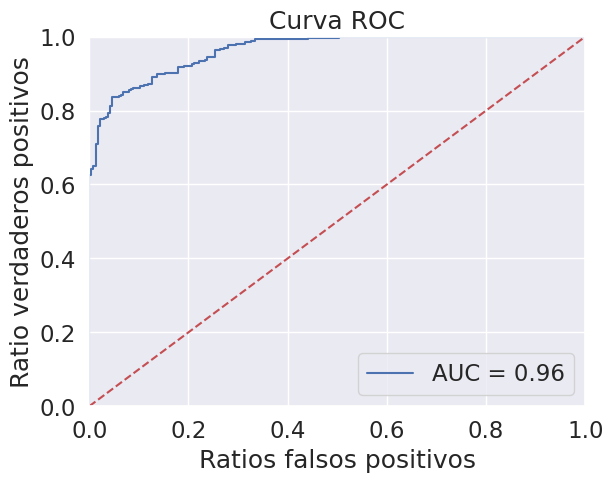

Area Under the Curve (the Closer to 1, the Better): 96.3%
Threshold value is: 0.6368098799563993


In [626]:
RF_th_proba = roc_auc_results(bb_scl.y_train,RF_mdl_fitted.predict_proba(bb_scl.X_train)[:,1])

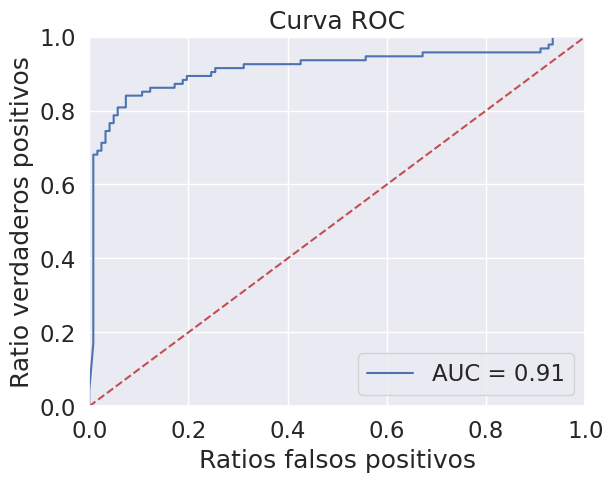

Area Under the Curve (the Closer to 1, the Better): 91.4%
Threshold value is: 0.6189344293443529


0.6189344293443529

In [627]:
roc_auc_results(bb_scl.y_test,RF_mdl_fitted.predict_proba(bb_scl.X_test)[:,1])

In [630]:
best_model_features_dict = {"best_model_params": RF_mdl_fitted.get_params()}
best_model_features_dict.update({"ROC": RF_th_proba})
best_model_features_dict

{'best_model_params': {'bootstrap': True,
  'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 5,
  'max_features': 'sqrt',
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 2,
  'min_samples_split': 20,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 50,
  'n_jobs': None,
  'oob_score': False,
  'random_state': 42,
  'verbose': 0,
  'warm_start': False},
 'ROC': 0.6368098799563993}

In [631]:
with open("best_model_features.yaml","w") as f:
    yaml.dump(best_model_features_dict,f)

In [ ]:
import pickle

with open("best_model.pkl","wb+") as fmodel:
    pickle.dump(RF_mdl_fitted, fmodel)